In [2]:
from src.target_cycliq import ParaTrans, ExpTarget, EvalCycliq
from src.eval_sedata import eval_undrained_cyc_torsion, eval_drained_cyc_torsion
from src.opt_pso2 import pso
import time, os, shutil
import pandas as pd

In [3]:
import os
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from PIL import Image as im

import numpy as np
import pandas as pd
import scipy

# --------------- font related start ---------------
font_path = "C:/Windows/font_others/times_simsun.ttf"
# font_path = "C:/Windows/font_others/arial_simhei.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
config = {
    'font.family': 'serif',
    'font.serif': [prop.get_name(), 'DejaVu Serif'],
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': [prop.get_name(), 'DejaVu Sans'],
    'font.size': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold'
}
rcParams.update(config)
# --------------- font related end ---------------

In [4]:
from typing import List, Dict, Tuple, Union, Callable
from matplotlib.axes import Axes

def plot_by_list(data_df: pd.DataFrame, plot_config: List[Tuple[Axes, str, str]], color: str, label: str = '', lw :float = 0.75):
    label_dict = {
        'p': r'$p \ (kPa)$',
        'q': r'$q \ (kPa)$',
        'tau': r'$\tau \ (kPa)$',
        'e_a': r'$\epsilon_{axial} \ (\%)$',
        'e_v': r'$\epsilon_{v} \ (\%)$',
        'e_q': r'$\epsilon_{q} \ (\%)$',
        'gamma': r'$\gamma \ (\%)$',
        'n': r'$N_{cycles}$',
        'e': r'$e$',
        'ru':r'$r_u$'
    }
    for ax_i, var1, var2 in plot_config:
        data_x = data_df[var2]
        data_y = data_df[var1]
        if var2 in ['e_a','e_v','gamma','e_q']:
            data_x = data_x * 100
        if var1 in ['e_a','e_v','gamma','e_q']:
            data_y = data_y * 100
        ax_i.plot(data_x, data_y, linewidth = lw, label = label,color = color)
        ax_i.set_xlabel(label_dict[var2])
        ax_i.set_ylabel(label_dict[var1])

def calculate_DA(temp_gamma: List[float]) -> List[float]:
    """
    Calculate the double amplitude strain (DA) for a given list of strains.
    
    The function computes the difference between the cumulative maximum and minimum 
    strains at each point in the list, which represents the DA at that point.

    Parameters:
    - temp_gamma (List[float]): List of strain values, typically 'gamma' from a DataFrame.

    Returns:
    - List[float]: List of DA values corresponding to each strain in 'temp_gamma'.
    """
    if not temp_gamma:
        return []

    list_DA = []
    temp_min = temp_gamma[0]
    temp_max = temp_gamma[0]

    # Initialize the first element as the difference of the same element
    list_DA.append(0.0)

    # Compute the DA starting from the second element
    for gamma_i in temp_gamma[1:]:
        temp_min = min(temp_min, gamma_i)
        temp_max = max(temp_max, gamma_i)
        list_DA.append(temp_max - temp_min)

    return list_DA

In [4]:
exp_dict1 = {
    'drained_mono_Tri':[
        [200, 0.765, 0.190],
        [200, 0.704, 0.160],
        [400, 0.707, 0.120],
        [800, 0.699, 0.050],
        [400, 0.764, 0.120],
        [600, 0.761, 0.070],
    ],
}

exp_dict2 = {
    'undrained_mono_Tri':[
        [100, 0.660, 0.190],
        [200, 0.642, 0.160],
        [300, 0.662, 0.120],
    ],
}

exp_dict3 = {
    'drained_mono_HCT':[
        [100, 0.756, 0.380],
        [100, 0.653, 0.250],
        [100, 0.667, 0.280],
    ],
}

exp_dict4 = {
    'undrained_mono_HCT':[
        [ 60, 0.761, 0.150],
        [100, 0.772, 0.170],
    ],
}

exp_dict5 = {
    'drained_cyc_HCT':[
        [200, 0.752, 0.200],
        [200, 0.646, 0.200],
    ],
}

exp_dict6 = {
    'undrained_cyc_HCT':[
        [200, 0.756, 0.151],
        [200, 0.763, 0.200],
        [200, 0.758, 0.250],
        [200, 0.705, 0.175],
        [200, 0.704, 0.200],
        [200, 0.653, 0.150],
        [200, 0.653, 0.175],
        [200, 0.638, 0.200],
    ],
}

exp_dict7 = {
    'undrained_cyc_HCT':[
        [200, 0.653, 0.151],
        [200, 0.646, 0.200],
        [200, 0.651, 0.250],
        [200, 0.704, 0.175],
        [200, 0.705, 0.200],
        [200, 0.756, 0.150],
        [200, 0.756, 0.175],
        [200, 0.771, 0.200],
    ],
}

exp_all0 = {**exp_dict3, **exp_dict4, **exp_dict5, **exp_dict7}

In [5]:
test_exp1 = {
    'drained_mono_HCT':[
        [100, 0.756, 0.380],
        [100, 0.653, 0.250],
        [100, 0.667, 0.280],
    ],
    'undrained_mono_HCT':[
        [ 60, 0.761, 0.150],
        [100, 0.772, 0.170],
    ],
    'drained_cyclic_HCT_5cyc':[
        [200, 0.752, 0.200],
        [200, 0.646, 0.200],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/coral/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'coral_calibration/'

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.8, # M
             0.025, # dre1
             30, # dre2
             0.05, # rdr
             300, # alpha
             0.8, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             1.0, # nb
             1.0, # nd
             9, # beta1
             0]
# para_list = [120, # G0
#              0.015, # Kappa
#              2.0, # h
#              1.0, # M
#              0.025, # dre1
#              30, # dre2
#              0.05, # rdr
#              300, # alpha
#              0.8, # dir
#              0.048, # lambdac
#              0.9, # ksi
#              1.07, # e0
#              2.2, # nb
#              6, # nd
#              9, # beta1
#              0]

para_list = [9.85884e+01,1.50000e-02,2.42542e+00,1.03342e+00,2.14111e-01,2.56214e+01,7.10036e-02,4.26168e+01,2.51124e+00,4.80000e-02,9.00000e-01,1.07000e+00,9.62688e-01,2.68008e-01,0.00000e+00,0.00000e+00]

test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)


In [ ]:
if True:
    for exp_type, exp_specs in test_exp1:
        match exp_type:
            case (
                'drained_cyclic_HCT' |
                'drained_cyclic_HCT_5cyc' |
                'undrained_cyclic_HCT' |
                'undrained_cyclic_HCT_liqcyc' |
                'undrained_cyclic_HCT_5cyc'
            ):
                for p_in, e_in, csr in exp_specs:
                    # data process
                    datafile_name = f'{exp_type.split('_')[0]}_HCT_p_{p_in:.0f}_ein_{e_in:.3f}_csr_{csr:.3f}'.replace('.', '_')+'.txt'
            case (
                'drained_cyclic_HCT' |
                'drained_cyclic_HCT_5cyc' |
                'undrained_cyclic_HCT' |
                'undrained_cyclic_HCT_liqcyc' |
                'undrained_cyclic_HCT_5cyc'
            ):
                for p_in, e_in, csr in exp_specs:
                    # data process
                    datafile_name = f'{exp_type.split('_')[0]}_HCT_p_{p_in:.0f}_ein_{e_in:.3f}_csr_{csr:.3f}'.replace('.', '_')+'.txt'
            case (
                'undrained_cyclic_Tri' 
            ):
                pass
            case (
                'drained_mono_Tri' |
                'undrained_mono_Tri'
            ):
                for p_in, e_in, e_a in exp_specs:
                    # data process
                    datafile_name = f'{exp_type.split('_')[0]}_Tri_p_{p_in:.0f}_ein_{e_in:.3f}_mono'.replace('.', '_')+'.txt'
            case (
                'drained_mono_HCT' |
                'undrained_mono_HCT'
            ):
                for p_in, e_in, e_s in exp_specs:
                    # data process
                    datafile_name = f'{exp_type.split('_')[0]}_HCT_p_{p_in:.0f}_ein_{e_in:.3f}_mono'.replace('.', '_')+'.txt'
            case (
                'undrained_cyclic_HCT_with_initial_shear'
            ):
                pass

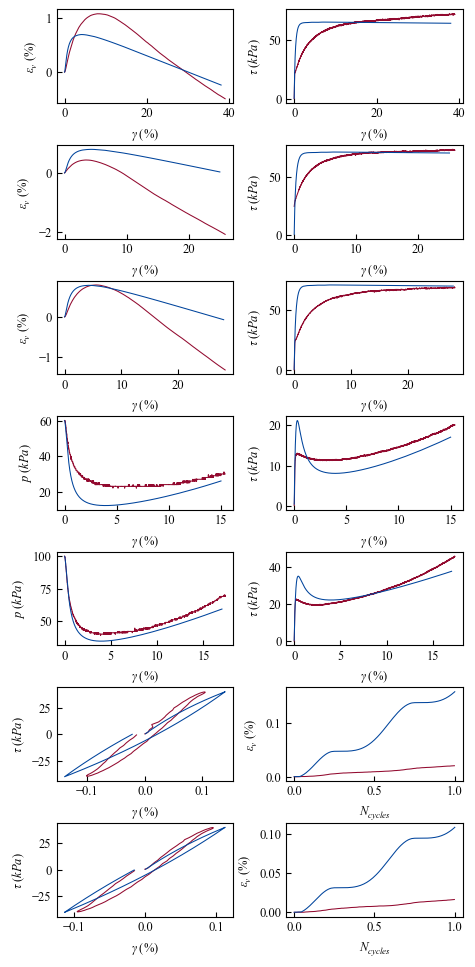

In [6]:
test_folder = 'target_exp/coral/'
simu_folder = 'coral_calibration/'

img_width = 12 # in centimeters
img_ratio = 1/2
nrows = 7
ncols = 2
top = 0.99
bottom = 0.03
left = 0.12
right = 0.98

hspace = 0.45
wspace = 0.3

fig = plt.figure(figsize = (img_width/2.54,img_width/img_ratio/2.54))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, top=top, bottom=bottom, right=right, left=left, wspace = wspace, hspace=hspace)
ax1  = fig.add_subplot(gs[0, 0])
ax2  = fig.add_subplot(gs[0, 1])
ax3  = fig.add_subplot(gs[1, 0])
ax4  = fig.add_subplot(gs[1, 1])
ax5  = fig.add_subplot(gs[2, 0])
ax6  = fig.add_subplot(gs[2, 1])
ax7  = fig.add_subplot(gs[3, 0])
ax8  = fig.add_subplot(gs[3, 1])
ax9  = fig.add_subplot(gs[4, 0])
ax10  = fig.add_subplot(gs[4, 1])
ax11  = fig.add_subplot(gs[5, 0])
ax12  = fig.add_subplot(gs[5, 1])
ax13  = fig.add_subplot(gs[6, 0])
ax14  = fig.add_subplot(gs[6, 1])

data_test = test_folder + 'drained_HCT_p_100_ein_0_756_mono.txt'
data_simu = simu_folder + 'drained_HCT_p_100_ein_0_756_mono.txt'

plot_by_list(pd.read_csv(data_test),[[ax1,'e_v','gamma'], [ax2,'tau','gamma']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[ax1,'e_v','gamma'], [ax2,'tau','gamma']], color = '#00449C')

data_test = test_folder + 'drained_HCT_p_100_ein_0_653_mono.txt'
data_simu = simu_folder + 'drained_HCT_p_100_ein_0_653_mono.txt'

plot_by_list(pd.read_csv(data_test),[[ax3,'e_v','gamma'], [ax4,'tau','gamma']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[ax3,'e_v','gamma'], [ax4,'tau','gamma']], color = '#00449C')

data_test = test_folder + 'drained_HCT_p_100_ein_0_667_mono.txt'
data_simu = simu_folder + 'drained_HCT_p_100_ein_0_667_mono.txt'

plot_by_list(pd.read_csv(data_test),[[ax5,'e_v','gamma'], [ax6,'tau','gamma']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[ax5,'e_v','gamma'], [ax6,'tau','gamma']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_60_ein_0_761_mono.txt'
data_simu = simu_folder + 'undrained_HCT_p_60_ein_0_761_mono.txt'

plot_by_list(pd.read_csv(data_test),[[ax7,'p','gamma'], [ax8,'tau','gamma']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[ax7,'p','gamma'], [ax8,'tau','gamma']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_100_ein_0_772_mono.txt'
data_simu = simu_folder + 'undrained_HCT_p_100_ein_0_772_mono.txt'

plot_by_list(pd.read_csv(data_test),[[ax9,'p','gamma'], [ax10,'tau','gamma']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[ax9,'p','gamma'], [ax10,'tau','gamma']], color = '#00449C')

data_test = test_folder + 'drained_HCT_p_200_ein_0_752_csr_0_200.txt'
data_simu = simu_folder + 'drained_HCT_p_200_ein_0_752_csr_0_200.txt'

df_test = pd.read_csv(data_test)
df_test = df_test[df_test['n'] < 1]
df_simu = pd.read_csv(data_simu)
df_simu = df_simu[df_simu['n'] < 1]

plot_by_list(df_test,[[ax11,'tau','gamma'], [ax12,'e_v','n']], color = '#920A2F')
plot_by_list(df_simu,[[ax11,'tau','gamma'], [ax12,'e_v','n']], color = '#00449C')

data_test = test_folder + 'drained_HCT_p_200_ein_0_646_csr_0_200.txt'
data_simu = simu_folder + 'drained_HCT_p_200_ein_0_646_csr_0_200.txt'

df_test = pd.read_csv(data_test)
df_test = df_test[df_test['n'] < 1]
df_simu = pd.read_csv(data_simu)
df_simu = df_simu[df_simu['n'] < 1]

plot_by_list(df_test,[[ax13,'tau','gamma'], [ax14,'e_v','n']], color = '#920A2F')
plot_by_list(df_simu,[[ax13,'tau','gamma'], [ax14,'e_v','n']], color = '#00449C')

fig.savefig('temp.png',dpi = 300)

In [70]:
test_exp1 = {
    # 'drained_mono_HCT':[
    #     [100, 0.756, 0.380],
    #     [100, 0.653, 0.250],
    #     [100, 0.667, 0.280],
    # ],
    'undrained_mono_HCT':[
        [ 60, 0.761, 0.150],
        [100, 0.772, 0.170],
    ],
    'drained_cyclic_HCT_5cyc':[
        [200, 0.752, 0.200],
        [200, 0.646, 0.200],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/coral/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'coral_calibration/'

para_list = [120, # G0
             0.015, # Kappa
             4.0, # h
             1.22, # M
             0.025, # dre1
             30, # dre2
             0.05, # rdr
             30, # alpha
             6.0, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             1.0, # nd
             0, # beta1
             0]

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.22, # M
             1.0, # dre1
             30, # dre2
             0.05, # rdr
             30, # alpha
             0.8, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             0.7, # nd
             6, # beta1
             0 ]

# para_list = [8.00000e+01,1.50000e-02,8.43260e-01,1.00000e+00,1.00000e-02,4.50000e+01,2.50000e-02,2.81343e+02,1.00000e+01,4.80000e-02,9.00000e-01,1.07000e+00,7.36200e-01,2.86938e+00,0.00000e+00,0.00000e+00]
# para_list = [9.62648e+01,1.50000e-02,3.00000e+00,1.00000e+00,1.26597e-01,4.50000e+01,2.50000e-02,3.00000e+02,1.00000e+01,4.80000e-02,9.00000e-01,1.07000e+00,7.00000e-01,1.00920e+00,0.00000e+00,0.00000e+00]

# para_list = [210, 0.01, 1.5, 1.1, 1.4, 30, 0.05, 30, 0.43, 0.0112, 0.715, 0.98, 2.2, 6, 9, 6]

test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)

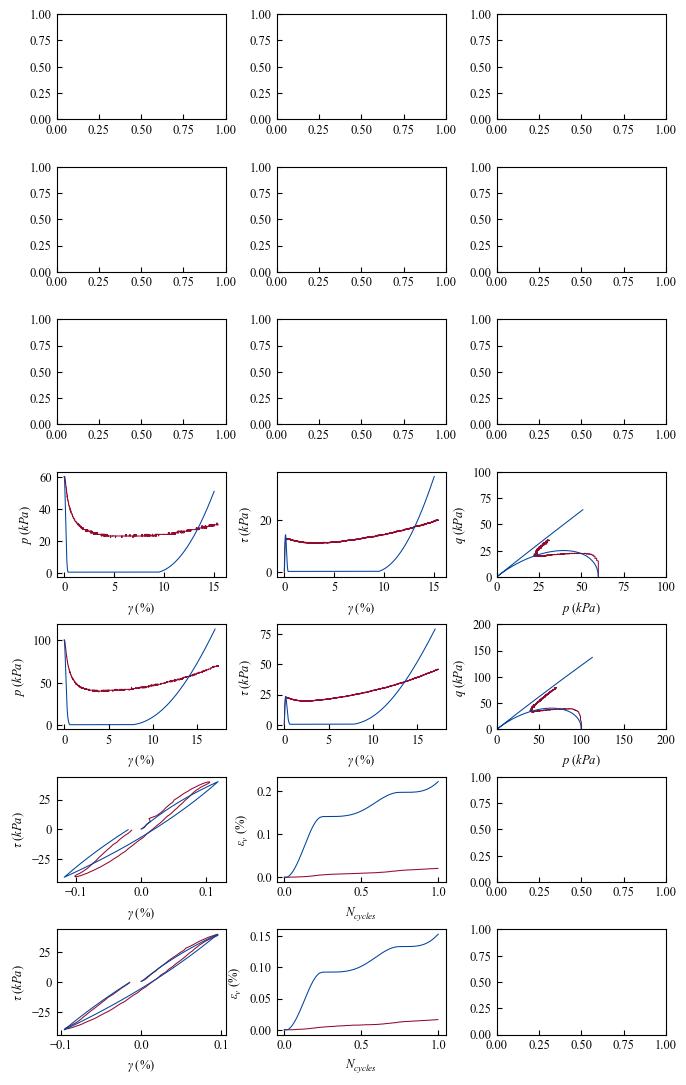

In [71]:
test_folder = 'target_exp/coral/'
simu_folder = 'coral_calibration/'

img_width = 18 # in centimeters
img_ratio = 1/1.5
nrows = 7
ncols = 2
top = 0.99
bottom = 0.03
left = 0.12
right = 0.98

hspace = 0.45
wspace = 0.3

fig,axes = plt.subplots(7,3,figsize = (img_width/2.54,img_width/img_ratio/2.54),sharex = False, sharey = False)
fig.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace = wspace, hspace=hspace)

axes_list = [item for sublist in axes for item in sublist]

# data_test = test_folder + 'drained_HCT_p_100_ein_0_756_mono.txt'
# data_simu = simu_folder + 'drained_HCT_p_100_ein_0_756_mono.txt'

# plot_by_list(pd.read_csv(data_test),[[axes[0,0],'e_v','gamma'], [axes[0,1],'tau','gamma'], [axes[0,2],'q','e_v']], color = '#920A2F')
# plot_by_list(pd.read_csv(data_simu),[[axes[0,0],'e_v','gamma'], [axes[0,1],'tau','gamma'], [axes[0,2],'q','e_v']], color = '#00449C')

# data_test = test_folder + 'drained_HCT_p_100_ein_0_653_mono.txt'
# data_simu = simu_folder + 'drained_HCT_p_100_ein_0_653_mono.txt'

# plot_by_list(pd.read_csv(data_test),[[axes[1,0],'e_v','gamma'], [axes[1,1],'tau','gamma'], [axes[1,2],'q','e_v']], color = '#920A2F')
# plot_by_list(pd.read_csv(data_simu),[[axes[1,0],'e_v','gamma'], [axes[1,1],'tau','gamma'], [axes[1,2],'q','e_v']], color = '#00449C')

# data_test = test_folder + 'drained_HCT_p_100_ein_0_667_mono.txt'
# data_simu = simu_folder + 'drained_HCT_p_100_ein_0_667_mono.txt'

# plot_by_list(pd.read_csv(data_test),[[axes[2,0],'e_v','gamma'], [axes[2,1],'tau','gamma'], [axes[2,2],'q','e_v']], color = '#920A2F')
# plot_by_list(pd.read_csv(data_simu),[[axes[2,0],'e_v','gamma'], [axes[2,1],'tau','gamma'], [axes[2,2],'q','e_v']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_60_ein_0_761_mono.txt'
data_simu = simu_folder + 'undrained_HCT_p_60_ein_0_761_mono.txt'

plot_by_list(pd.read_csv(data_test),[[axes[3,0],'p','gamma'], [axes[3,1],'tau','gamma'], [axes[3,2],'q','p']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[axes[3,0],'p','gamma'], [axes[3,1],'tau','gamma'], [axes[3,2],'q','p']], color = '#00449C')

axes[3,2].set_xlim([0,100])
axes[3,2].set_ylim([0,100])

data_test = test_folder + 'undrained_HCT_p_100_ein_0_772_mono.txt'
data_simu = simu_folder + 'undrained_HCT_p_100_ein_0_772_mono.txt'

plot_by_list(pd.read_csv(data_test),[[axes[4,0],'p','gamma'], [axes[4,1],'tau','gamma'], [axes[4,2],'q','p']], color = '#920A2F')
plot_by_list(pd.read_csv(data_simu),[[axes[4,0],'p','gamma'], [axes[4,1],'tau','gamma'], [axes[4,2],'q','p']], color = '#00449C')

axes[4,2].set_xlim([0,200])
axes[4,2].set_ylim([0,200])

data_test = test_folder + 'drained_HCT_p_200_ein_0_752_csr_0_200.txt'
data_simu = simu_folder + 'drained_HCT_p_200_ein_0_752_csr_0_200.txt'

df_test = pd.read_csv(data_test)
df_test = df_test[df_test['n'] < 1]
df_simu = pd.read_csv(data_simu)
df_simu = df_simu[df_simu['n'] < 1]

plot_by_list(df_test,[[axes[5,0],'tau','gamma'], [axes[5,1],'e_v','n']], color = '#920A2F')
plot_by_list(df_simu,[[axes[5,0],'tau','gamma'], [axes[5,1],'e_v','n']], color = '#00449C')

data_test = test_folder + 'drained_HCT_p_200_ein_0_646_csr_0_200.txt'
data_simu = simu_folder + 'drained_HCT_p_200_ein_0_646_csr_0_200.txt'

df_test = pd.read_csv(data_test)
df_test = df_test[df_test['n'] < 1]
df_simu = pd.read_csv(data_simu)
df_simu = df_simu[df_simu['n'] < 1]

plot_by_list(df_test,[[axes[6,0],'tau','gamma'], [axes[6,1],'e_v','n']], color = '#920A2F')
plot_by_list(df_simu,[[axes[6,0],'tau','gamma'], [axes[6,1],'e_v','n']], color = '#00449C')

fig.savefig('temp.png',dpi = 300)

In [94]:
test_exp1 = {
    'undrained_cyclic_HCT':[
        [200, 0.771, 0.200],
        [200, 0.756, 0.175],
        [200, 0.705, 0.200],
        [200, 0.646, 0.200],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/coral/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'coral_calibration/'

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.22, # M
             0.5, # dre1
             30, # dre2
             0.01, # rdr
             30, # alpha
             0.1, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             0.7, # nd
             6, # beta1
             0 ]

test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)

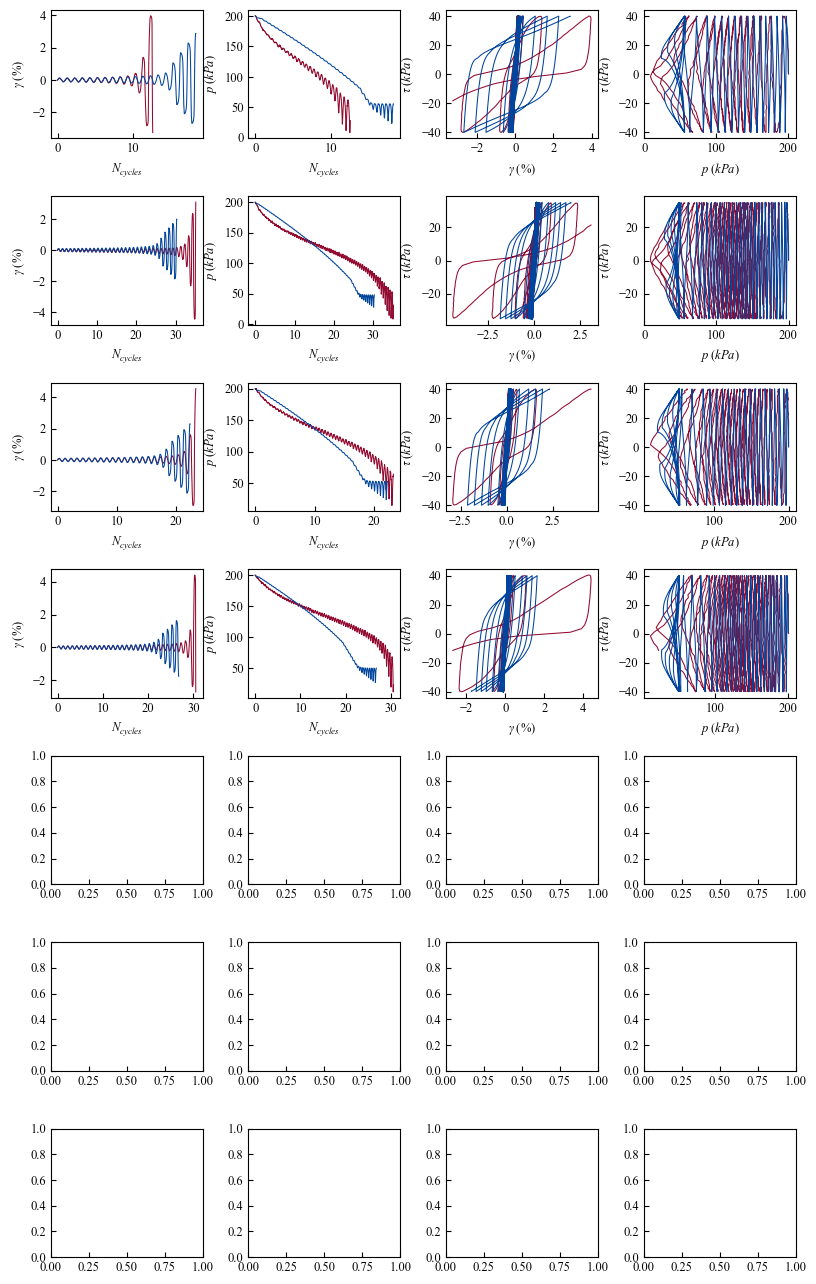

In [95]:
test_folder = 'target_exp/coral/'
simu_folder = 'coral_calibration/'

img_width = 22 # in centimeters
img_ratio = 1/1.5
nrows = 7
ncols = 2
top = 0.99
bottom = 0.03
left = 0.12
right = 0.98

hspace = 0.45
wspace = 0.3

def pre_plot(file_name, DA_lim = 0.075):
    temp_df = pd.read_csv(file_name)
    temp_df['DA'] = calculate_DA(temp_df['gamma'].tolist())
    return temp_df[temp_df['DA'] < DA_lim].copy()


fig,axes = plt.subplots(7,4,figsize = (img_width/2.54,img_width/img_ratio/2.54),sharex = False, sharey = False)
fig.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace = wspace, hspace=hspace)

axes_list = [item for sublist in axes for item in sublist]


data_test = test_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'


plot_by_list(pre_plot(data_test),[[axes[0,0],'gamma','n'], [axes[0,1],'p','n'], [axes[0,2],'tau','gamma'], [axes[0,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[0,0],'gamma','n'], [axes[0,1],'p','n'], [axes[0,2],'tau','gamma'], [axes[0,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'

plot_by_list(pre_plot(data_test),[[axes[1,0],'gamma','n'], [axes[1,1],'p','n'], [axes[1,2],'tau','gamma'], [axes[1,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[1,0],'gamma','n'], [axes[1,1],'p','n'], [axes[1,2],'tau','gamma'], [axes[1,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'

plot_by_list(pre_plot(data_test),[[axes[2,0],'gamma','n'], [axes[2,1],'p','n'], [axes[2,2],'tau','gamma'], [axes[2,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[2,0],'gamma','n'], [axes[2,1],'p','n'], [axes[2,2],'tau','gamma'], [axes[2,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'

plot_by_list(pre_plot(data_test),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#00449C')


fig.savefig('temp.png',dpi = 300)

In [119]:
test_exp1 = {
    'undrained_cyclic_HCT':[
        [200, 0.771, 0.200],
        [200, 0.756, 0.175],
        [200, 0.705, 0.200],
        [200, 0.646, 0.200],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/coral/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'coral_calibration/'

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.22, # M
             0.5, # dre1
             300, # dre2
             0.01, # rdr
             30, # alpha
             0.1, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             0.7, # nd
             6, # beta1
             0 ]

para_list = [102.95233024757474,0.015,1.9564154380661432,1.3818824513618597,0.5,36.452116615329054,0.09571475920727143,3.0,0.920901021837129,0.048,0.9,1.07,1.021748047694607,7.110300073271395,9.0,6.0]


test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)

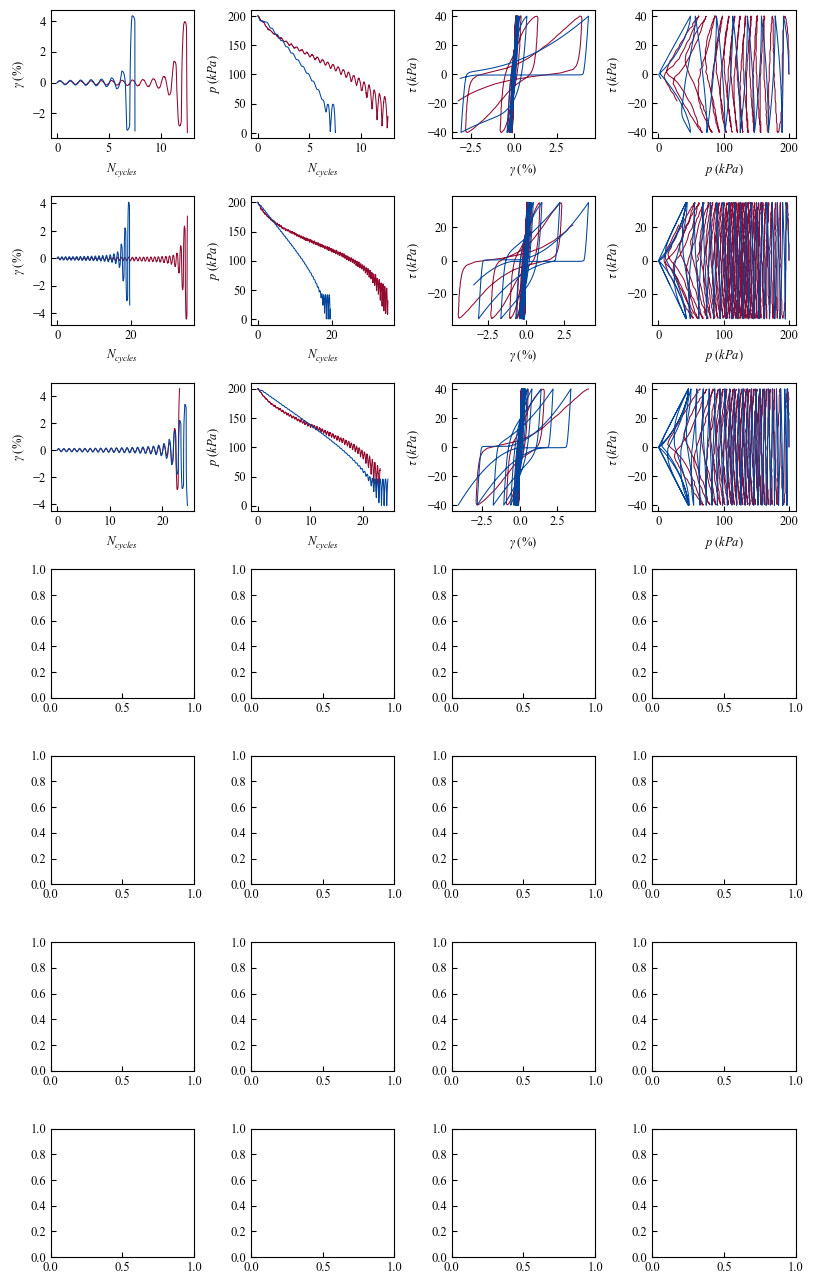

In [124]:
test_folder = 'target_exp/coral/'
simu_folder = 'coral_calibration/'

img_width = 22 # in centimeters
img_ratio = 1/1.5
nrows = 7
ncols = 2
top = 0.99
bottom = 0.03
left = 0.12
right = 0.98

hspace = 0.45
wspace = 0.4

def pre_plot(file_name, DA_lim = 0.075):
    temp_df = pd.read_csv(file_name)
    temp_df['DA'] = calculate_DA(temp_df['gamma'].tolist())
    return temp_df[temp_df['DA'] < DA_lim].copy()


fig,axes = plt.subplots(7,4,figsize = (img_width/2.54,img_width/img_ratio/2.54),sharex = False, sharey = False)
fig.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace = wspace, hspace=hspace)

axes_list = [item for sublist in axes for item in sublist]


data_test = test_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'


plot_by_list(pre_plot(data_test),[[axes[0,0],'gamma','n'], [axes[0,1],'p','n'], [axes[0,2],'tau','gamma'], [axes[0,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[0,0],'gamma','n'], [axes[0,1],'p','n'], [axes[0,2],'tau','gamma'], [axes[0,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'

plot_by_list(pre_plot(data_test),[[axes[1,0],'gamma','n'], [axes[1,1],'p','n'], [axes[1,2],'tau','gamma'], [axes[1,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[1,0],'gamma','n'], [axes[1,1],'p','n'], [axes[1,2],'tau','gamma'], [axes[1,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'

plot_by_list(pre_plot(data_test),[[axes[2,0],'gamma','n'], [axes[2,1],'p','n'], [axes[2,2],'tau','gamma'], [axes[2,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[2,0],'gamma','n'], [axes[2,1],'p','n'], [axes[2,2],'tau','gamma'], [axes[2,3],'tau','p']], color = '#00449C')

# data_test = test_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'
# data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'

# plot_by_list(pre_plot(data_test),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#920A2F')
# plot_by_list(pre_plot(data_simu),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#00449C')


fig.savefig('temp.png',dpi = 300)

In [ ]:
test_exp1 = {
    'undrained_cyclic_HCT':[
        [200, 0.771, 0.200],
        [200, 0.756, 0.175],
        [200, 0.705, 0.200],
        [200, 0.646, 0.200],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/coral/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'coral_calibration/'

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.22, # M
             0.5, # dre1
             300, # dre2
             0.01, # rdr
             30, # alpha
             0.1, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             0.7, # nd
             6, # beta1
             0 ]

para_list = [102.95233024757474,
             0.015,
             1.9564154380661432,
             1.3818824513618597,
             0.5,
             36.452116615329054,
             0.09571475920727143,
             3.0,
             0.820901021837129,
             0.048,
             0.9,
             1.07,
             1.021748047694607,
             7.110300073271395,
             9.0,
             6.0]


test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)

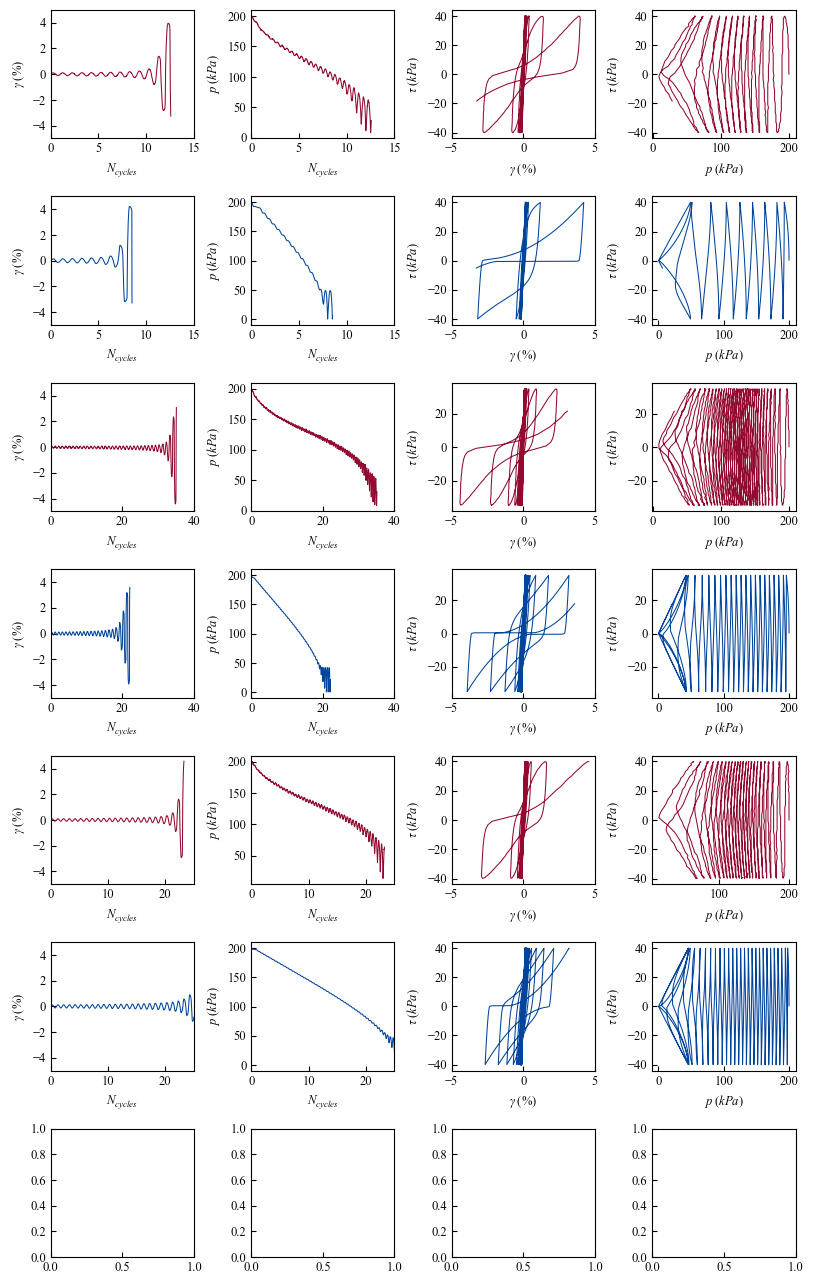

In [132]:
test_folder = 'target_exp/coral/'
simu_folder = 'coral_calibration/'

img_width = 22 # in centimeters
img_ratio = 1/1.5
nrows = 7
ncols = 2
top = 0.99
bottom = 0.03
left = 0.12
right = 0.98

hspace = 0.45
wspace = 0.4

def pre_plot(file_name, DA_lim = 0.075):
    temp_df = pd.read_csv(file_name)
    temp_df['DA'] = calculate_DA(temp_df['gamma'].tolist())
    return temp_df[temp_df['DA'] < DA_lim].copy()


fig,axes = plt.subplots(7,4,figsize = (img_width/2.54,img_width/img_ratio/2.54),sharex = False, sharey = False)
fig.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace = wspace, hspace=hspace)

axes_list = [item for sublist in axes for item in sublist]


data_test = test_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_771_csr_0_200.txt'


plot_by_list(pre_plot(data_test),[[axes[0,0],'gamma','n'], [axes[0,1],'p','n'], [axes[0,2],'tau','gamma'], [axes[0,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[1,0],'gamma','n'], [axes[1,1],'p','n'], [axes[1,2],'tau','gamma'], [axes[1,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_756_csr_0_175.txt'

plot_by_list(pre_plot(data_test),[[axes[2,0],'gamma','n'], [axes[2,1],'p','n'], [axes[2,2],'tau','gamma'], [axes[2,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#00449C')

data_test = test_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'
data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_705_csr_0_200.txt'

plot_by_list(pre_plot(data_test),[[axes[4,0],'gamma','n'], [axes[4,1],'p','n'], [axes[4,2],'tau','gamma'], [axes[4,3],'tau','p']], color = '#920A2F')
plot_by_list(pre_plot(data_simu),[[axes[5,0],'gamma','n'], [axes[5,1],'p','n'], [axes[5,2],'tau','gamma'], [axes[5,3],'tau','p']], color = '#00449C')

axes[0,0].set_xlim([0,15])
axes[1,0].set_xlim([0,15])
axes[0,0].set_ylim([-4,4])
axes[1,0].set_ylim([-4,4])

axes[0,1].set_xlim([0,15])
axes[1,1].set_xlim([0,15])

axes[2,0].set_xlim([0,40])
axes[3,0].set_xlim([0,40])
axes[2,1].set_xlim([0,40])
axes[3,1].set_xlim([0,40])

axes[4,0].set_xlim([0,25])
axes[5,0].set_xlim([0,25])
axes[4,1].set_xlim([0,25])
axes[5,1].set_xlim([0,25])

axes[0,2].set_xlim([-5,5])
axes[1,2].set_xlim([-5,5])
axes[2,2].set_xlim([-5,5])
axes[3,2].set_xlim([-5,5])
axes[4,2].set_xlim([-5,5])
axes[5,2].set_xlim([-5,5])

axes[0,0].set_ylim([-5,5])
axes[1,0].set_ylim([-5,5])
axes[2,0].set_ylim([-5,5])
axes[3,0].set_ylim([-5,5])
axes[4,0].set_ylim([-5,5])
axes[5,0].set_ylim([-5,5])

# data_test = test_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'
# data_simu = simu_folder + 'undrained_HCT_p_200_ein_0_646_csr_0_200.txt'

# plot_by_list(pre_plot(data_test),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#920A2F')
# plot_by_list(pre_plot(data_simu),[[axes[3,0],'gamma','n'], [axes[3,1],'p','n'], [axes[3,2],'tau','gamma'], [axes[3,3],'tau','p']], color = '#00449C')


fig.savefig('temp.png',dpi = 300)

In [110]:
file_list = ['undrained_HCT_p_200_ein_0_771_csr_0_200',
            #  'undrained_HCT_p_200_ein_0_756_csr_0_175',
             'undrained_HCT_p_200_ein_0_705_csr_0_200',
             'undrained_HCT_p_200_ein_0_646_csr_0_200',
             ]

for result_file in file_list:
    data_df = pd.read_csv(simu_folder + result_file + '.txt')
    
    temp_df = data_df[data_df['tau'] > 0.95 * 0.2 * 200].copy()
    temp_df['eta'] = temp_df['q']/temp_df['p']
    temp_eta = temp_df['eta'].quantile(0.99)
    print(f'eta of {result_file}: {temp_eta}')

eta of undrained_HCT_p_200_ein_0_771_csr_0_200: 1.2430696430911428
eta of undrained_HCT_p_200_ein_0_705_csr_0_200: 1.320855439084772
eta of undrained_HCT_p_200_ein_0_646_csr_0_200: 1.3943894771716756
